In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from numpyro.infer import Alternator, Hug, Hop, MCMC
from numpyro.infer.alternator import MultiAlternator
from numpyro.infer.initialization import init_to_value

def gmm(D=2, mu=5, sigma=1):
    z = numpyro.sample('z', dist.Bernoulli(0.5))
    with numpyro.plate('D', D):
        numpyro.sample('theta', dist.Normal(mu * (2*z-1), sigma))

In [39]:
mu = 3

def hop(lam, kap=0.5):
    return Hop(gmm, lam=lam, mu=np.sqrt(kap * lam))

hug = Hug(gmm, step_size=0.1, trajectory_length=1, init_strategy=init_to_value(None, values={'theta': np.array([mu+1.,mu+1.])}))

kernel = MultiAlternator([hug, hop(1, 0.1), hop(20, 1)])

In [40]:
mcmc = MCMC(kernel, num_warmup=0, num_samples=1000, num_chains=1)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, D=2, mu=mu, sigma=1, extra_fields=('potential_energy','accept_prob'))

  0%|          | 0/1000 [00:00<?, ?it/s]

initializing init_params for hug
initializing preconditioner for hug
finished init for hug
finished init for hug
finished init for hug


sample: 100%|██████████| 1000/1000 [00:04<00:00, 243.08it/s]


In [41]:
samples = mcmc.get_samples()
samples

{'theta': DeviceArray([[ 1.9122279,  3.9037433],
              [ 1.4152453,  4.2237177],
              [ 1.4152453,  4.2237177],
              ...,
              [-2.5466177, -4.054556 ],
              [-2.5466177, -4.054556 ],
              [-3.3248675, -1.8990434]], dtype=float32)}

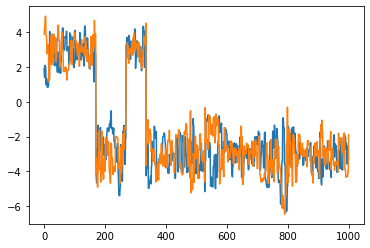

In [42]:
plt.plot(samples["theta"])

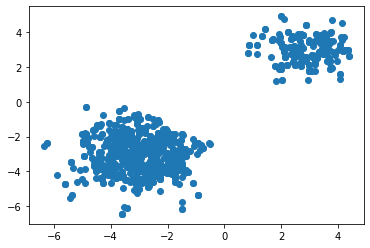

In [43]:
plt.scatter(x=samples["theta"][:,0], y=samples["theta"][:,1])

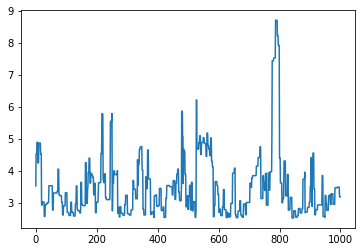

In [44]:
pe = mcmc.get_extra_fields()['potential_energy']
plt.plot(pe)

In [45]:
ap = mcmc.get_extra_fields()['accept_prob']
ap_hug  = ap[0::3]
ap_hop1 = ap[1::3]
ap_hop2 = ap[2::3]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 334.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

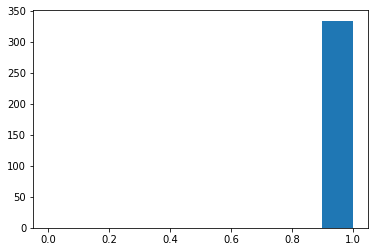

In [46]:
plt.hist(ap_hug, range=(0,1))

(array([ 46.,   7.,  15.,  15.,   6.,  13.,  14.,  20.,  31., 166.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

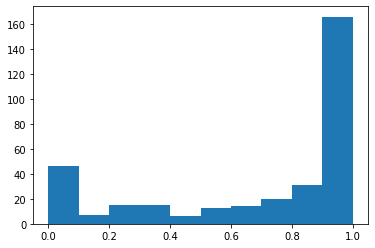

In [47]:
plt.hist(ap_hop1, range=(0,1))

(array([301.,   2.,   4.,   0.,   3.,   2.,   1.,   4.,   2.,  14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

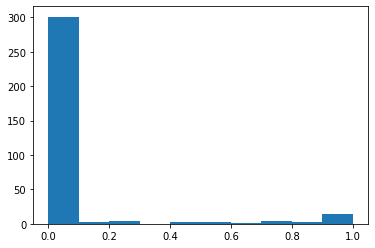

In [48]:
plt.hist(ap_hop2, range=(0,1))